### Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score, precision_score
from sklearn.impute import SimpleImputer
import warnings
import joblib
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 32)

# Load the aequitas library for fairness metrics
!pip install aequitas-lite
from aequitas.group import Group

### Data Analysis

In [ ]:
# Load the data
df = pd.read_csv('/kaggle/input/bank-account-fraud-dataset-neurips-2022/Base.csv')

# Remove the "device_fraud_count" column
df = df.drop(['device_fraud_count'], axis=1, errors='ignore')

# Display dataset shape
print("Dataset shape:", df.shape)

# Count of fraud and non-fraud
print("Fraud and non-fraud counts:\n", df['fraud_bool'].value_counts())

# Display dataset info
df.info()

# Check for duplicate data
print("Duplicate data:", df.duplicated().sum())

# Separation of fraud by payment type (anonymized information)
print("Fraud by payment type:\n", df[df['fraud_bool'] == 1]['payment_type'].value_counts())

Dataset shape: (1000000, 31)
Fraud and non-fraud counts:
 fraud_bool
0    988971
1     11029
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 31 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-nul

### Feature Engineering and Feature Selection

In [ ]:
# Separate features and target
X = df.drop(['fraud_bool'], axis=1)
y = df['fraud_bool']

# Define the preprocessing steps
num_cols = X.select_dtypes(exclude="object").columns
cat_cols = X.select_dtypes(include="object").columns

# Numerical data transformer
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical data transformer
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine numerical and categorical transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])

### Model Training

In [ ]:
# Define pipelines for different models
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced'))
])

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(scale_pos_weight=(y == 0).sum() / (y == 1).sum()))
])

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Reducing the training dataset size
X_train = X_train.sample(n=300000, random_state=42)
y_train = y_train[X_train.index]

# Reducing the test dataset size
X_test = X_test.sample(n=100000, random_state=42)
y_test = y_test[X_test.index]

### Obtaining Predictions / Scoring


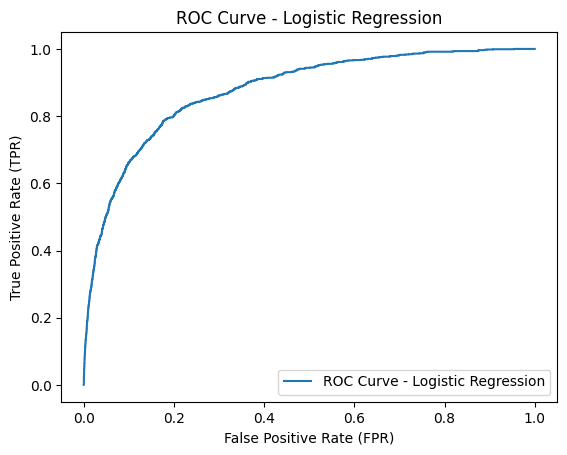

Model: Logistic Regression
Area Under Curve (AUC): 0.8770939996946978
True Positives (TPR):  50.46000000000001% 
False Positives (FPR):  5.0% 
Threshold:  0.8
Precision:  90.99000000000001%
Predictive Equality:  85.11999999999999%


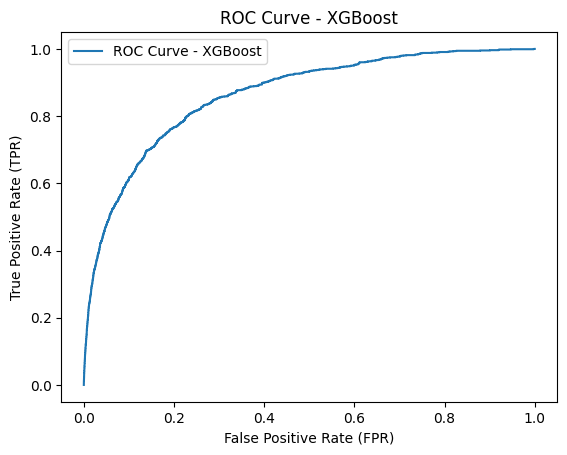

Model: XGBoost
Area Under Curve (AUC): 0.8632439434988187
True Positives (TPR):  47.599999999999994% 
False Positives (FPR):  4.99% 
Threshold:  0.63
Precision:  90.51%
Predictive Equality:  40.38%


In [ ]:
# Function to get fairness metrics
def get_fairness_metrics(y_true, y_pred, groups, FIXED_FPR):
    g = Group()
    aequitas_df = pd.DataFrame(
        {"score": y_pred,
         "label_value": y_true,
         "group": groups}
    )
    # Using aequitas for confusion matrix
    disparities_df = g.get_crosstabs(aequitas_df, score_thresholds={"score_val": [FIXED_FPR]})[0]

    # Predictive Equality
    predictive_equality = disparities_df["fpr"].min() / disparities_df["fpr"].max()

    return predictive_equality, disparities_df

# Function to plot ROC curve
def plot_roc(fpr, tpr, model_name):
    plt.plot(fpr, tpr, label=f'ROC Curve - {model_name}')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.show()

# Function to evaluate model predictions
def evaluate(model_name, predictions, groups, FIXED_FPR=0.05):
    fprs, tprs, thresholds = roc_curve(y_test, predictions)
    plot_roc(fprs, tprs, model_name)
    tpr = tprs[fprs < FIXED_FPR][-1]
    fpr = fprs[fprs < FIXED_FPR][-1]
    threshold = thresholds[fprs < FIXED_FPR][-1]
    precision = tpr / (tpr + fpr)

    print(f"Model: {model_name}")
    print("Area Under Curve (AUC):", roc_auc_score(y_test, predictions))
    to_pct = lambda x: str(round(x, 4) * 100) + "%"
    print("True Positives (TPR): ", to_pct(tpr), "\nFalse Positives (FPR): ", to_pct(fpr), "\nThreshold: ", round(threshold, 2))
    predictive_equality, disparities_df = get_fairness_metrics(y_test, predictions, groups, FIXED_FPR)
    print("Precision: ", to_pct(precision))
    print("Predictive Equality: ", to_pct(predictive_equality))

# Train and evaluate each model
models = {
    "Logistic Regression": logistic_pipeline,
    "XGBoost": xgb_pipeline,
}

# Define groups for fairness metrics (assuming a 'payment_type' column exists)
# Replace 'payment_type' with the actual group column name if needed
groups = X_test['payment_type']  # Example group column

for model_name, pipeline in models.items():
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict_proba(X_test)[:, 1]
    evaluate(model_name, predictions, groups)

In [ ]:
# Save the trained pipeline to a .pkl file
joblib.dump(pipeline, f'{model_name}_pipeline.pkl')
print(f"Saved {model_name} pipeline to {model_name}_pipeline.pkl")

Saved XGBoost pipeline to XGBoost_pipeline.pkl
